# Line Emission Model

Exploring a geometrically correct emission model for lines emitted at an infinitely thin surface

In [1]:
import sys ; sys.path.append('../')
import os

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator



## Constants and Utility functions

In [2]:
c_light = 2.99792458e10
h_planck = 6.62607015e-27 
c2_rad = 1.4387768775039339e0 # h*c/kB in cm K
stefan_boltzmann = 5.670374419184429453970e-5

G_Msun = 1.32712442099e26 
G_Newton = 6.67430e-8
Msun = G_Msun/G_Newton
Rsun = 6.96340e10

m_hydrogen = 1.6735575e-24
k_boltzmann = 1.380649e-16

Rau = 1.495978707e13


## Here is our forward model for the line emission

In [3]:
class Z_surf:
    """Simple model for a surface height"""
    def __init__(self, h0, R0, alpha):
        self._h0 = h0
        self._R0 = R0 
        self._a = alpha 

    def __call__(self, R):
        x = R/self._R0
        return self._h0 * self._R0 * x**(1+self._a)  * np.exp(-x)

    def dzdR(self, R):
        x = R/self._R0
        return self._h0 * x**self._a  * np.exp(-x) * (1+self._a - x)

    def max_aspect(self): # Needed to determine if we might see under the disc.
        """Get the maximum aspect ratio"""
        x = self._a
        return  self._h0 * x**self._a  * np.exp(-x)

class V_Kep:
    """Keplerian Rotation Velocity"""
    def __init__(self, Mstar):
        self._M = Mstar 

    def __call__(self, R, Z):
        r = np.hypot(R, Z)
        return np.sqrt(G_Msun*self._M/(r*Rau))

class ThermalLineWidth:
    """Width of the line"""
    def __init__(self, v0, R0, alpha):
        self._v0 = v0
        self._R0 = R0 
        self._a = alpha 

    def __call__(self, R, Z):
        x = R/self._R0
        return self._v0 * x**self._a 



In [4]:

class ThinSurfaceEmissionModel:
    """Simple model of line emission from an infinitely thin surface in a disc.

    Parameters
    ----------
    xpix : 1D array
        Location of the pixel centers in the x-direction
    ypix : 1D array
        Location of the pixel centers in the y-direction
    zR : function, f(R) -> z
        The height of the emission surface as a function of radius
    vRz : function, f(R, z) -> v
        Rotational velocity as a function of R and z
    wRz : function, f(R, z) -> w
        Line width as a function of R and z
    IR : function, f(R) -> I
        Line centre emission intensity as a function of R and z
    tauR : function, f(R) -> tau 
        Line center optical depth
    line_prof : function f(v, w) -> f
        Shape of the emission line profile as a function of center velocity
        and width
    inc : float, unit=radians:
        inclination of the disc.
    zB : function, f(R) -> z, optional
        The height of the back surface emission surface. If not provided zB = - zR will
        be assumed.
    verbose : bool, default=True
        If True,  surface finding method with report results
    """
    def __init__(self, xpix, ypix, zR, vRz, wRz, IR, tauR, line_prof, inc, zB=None, verbose=True):

        self._verbose = verbose

        self._x1D = xpix
        self._y1D = ypix 

        self._xg, self._yg = np.meshgrid(xpix, ypix, indexing='ij')

        self._zfun = zR
        self._zBfun = zB
        self._vfun = vRz
        self._wfun = wRz

        self._Ifun = IR
        self._tau_fun = tauR
        self._line_prof = line_prof

        self._inc = inc 

        self._solve_surf() 
        self._back = None

    def _get_z_fun(self, front):
        if front:
            return self._zfun
        else:
            if self._zBfun:
                return self._zBfun
            else:
                f = lambda R: -self._zfun(R) 
                f.dzdR = lambda R: -self._zfun.dzdR(R)
                f.max_aspect = self._zfun.max_aspect
                return f
            
    def _surf_iter(self, xm, ym, zR, max_iter):
        """Find the surface using Newton-Raphson iteration"""
        
        # We will use the pixel size to check convergence.   
        #    Needed otherwise x=0, y=0 pixel might never converge.
        dR = (np.max(self._x1D) - np.min(self._x1D))/len(self._x1D)
        
        tan_i = np.tan(self._inc)

        def f(R):
            y_tmp =  ym - zR(R)*tan_i
            f = R*R - (xm*xm +  y_tmp*y_tmp)
            dfdR = 2*R + 2*tan_i * zR.dzdR(R) * y_tmp
            return f, dfdR

        R = np.hypot(xm, ym)
        for i in range(max_iter):
            fi, dfi = f(R)
            step = np.clip(-fi/dfi, -0.9*R, np.inf)
            Rn = R + step

            converged = np.abs(step) < np.maximum(1e-12*Rn, 1e-6*dR)
            if np.all(converged):
                break 
            R = Rn

        if self._verbose:
            print(f'Iterations={i+1}')
        
        return Rn, converged

    def _slow_surf_iter(self, xm, ym, zR, direction, max_iter):
        """Use Newton Raphson solution, starting with neighbouring cells to
        help find the correct solution at high inclinations
        """

        # We will use the pixel size to check convergence.   
        #    Needed otherwise x=0, y=0 pixel might never converge.
        dR = (np.max(self._x1D) - np.min(self._x1D))/len(self._x1D)
        
        tan_i = np.tan(self._inc)

        def f(R, x, y):
            y_tmp = y - zR(R)*tan_i
            f = R*R - (x*x +  y_tmp*y_tmp)
            dfdR = 2*R + 2*tan_i * zR.dzdR(R) * y_tmp
            return f, dfdR

        R = np.hypot(xm, ym)
        Ri = R[:, direction].copy()
        converged = (R == R)

        imax = 0
        for idx in np.arange(0, R.shape[1])[::direction]:
            for iter in range(max_iter):
                fi, dfi = f(Ri, xm[:, idx], ym[:, idx])
                step = np.clip(-fi/dfi, -0.9*Ri, np.inf)
                Rn = Ri + step

                converged[:, idx] = np.abs(step) < np.maximum(1e-12*Rn, 1e-6*dR)
                Ri = Rn
                if np.all(converged[:, idx]):
                    break 
            R[:, idx] = Ri
            imax = max(imax, iter)


        num_failed = np.sum(~converged)
        if num_failed:
            
            # Find the non-converged cells and try again with a different guess.
            idx_x, idx_y = np.where(~converged)

            Ri = R[idx_x, idx_y+direction].copy()
            for iter in range(max_iter):
                fi, dfi = f(Ri, xm[idx_x, idx_y], ym[idx_x, idx_y])
                step = np.clip(-fi/dfi, -0.9*Ri, np.inf)
                Rn = Ri + step

                converged2 = np.abs(step) < np.maximum(1e-12*Rn, 1e-6*dR)
                Ri = Rn
                if np.all(converged2):
                    break 
            
            R[idx_x[converged2], idx_y[converged2]]
            converged[idx_x[converged2], idx_y[converged2]] = True
            imax += iter + 1

            num_stil_failed = np.sum(~converged2)
            if num_stil_failed:
                msg = f'{num_failed} pixels failed. {num_stil_failed} still failed after a second attempt'
            else:
                msg = f'Repaired {num_failed} failed pixels'
            
            if self._verbose:
                print(msg, end=', ', flush=False)


        if self._verbose:
            print(f'Iterations={imax+1}')

        return R, converged
            



    def _solve_surf(self, max_iter=100, do_front=True):
        """Locate the emission surface (R, z, phi), in each pixel.

        Parameters
        ----------
        max_iter : int
            Maximum of iterations to use when searching for z(R)
        front : bool
            If true, we find the front surface. Otherwise, we find the
            back.    
        """

        # Intial guess, assume z = 0
        zR = self._get_z_fun(do_front)
        xm, ym = self._xg, self._yg / np.cos(self._inc)

        if self._verbose:
            print(f'front={do_front}, ', end='', flush=False)

        if np.abs(zR.max_aspect() * np.tan(self._inc)) > 0.5:
            if self._verbose:
                print('slow=True, ', end='', flush=False)
                
            direction = (1*(do_front==True)) - (1*(do_front==False)) 
            R, converged = self._slow_surf_iter(xm, ym, zR, direction, max_iter)
        else:
            R, converged = self._surf_iter(xm, ym, zR, max_iter)


        # Save the results
        if do_front:
            self._front = {
                'R' : R, 
                'Z' : zR(R),
                'cos_phi' : np.where(R > 0,xm/R, 0),
                'failed' : ~converged
            }
        else:
            self._back = {
                'R' : R, 
                'Z' : zR(R),
                'cos_phi' : np.where(R > 0, xm/R, 0),
                'failed' : ~converged
            }


    def _get_velocities(self, surf):
        # Z velocity
        v_circ = self._vfun(surf['R'], surf['Z'])
        vZ = v_circ * surf['cos_phi'] * np.sin(self._inc)

        # Line width:
        w =  self._wfun(surf['R'], surf['Z'])

        return vZ, w



    def compute_channel_mask(self, v_channel, back=False, v_width=1):
        """Compute locations where emission is at the specified velocity.
        
        Parameters
        ----------
        v_channel : float,
            Velocity to compute the emission at
        
        Returns
        -------
        mask : 2D array of bool
            Locations where emssion with (vZ-v_channel) < line_width*v_width
        v_width : float, default = 1
            Number of line widths to use when making the mask

        Notes
        -----
        If the back side is requested any locations obscurred by front-side emission 
        will be removed.
        """

        # Compute the location of the front emission
        vZ, lw = self._get_velocities(self._front)

        mask = np.abs(vZ - v_channel) < lw*v_width

        if back:
            # If we want the back-side emission, compute it and mask out the front
            if self._back is None:
                self._solve_surf(do_front=False)

            vZ, lw = self._get_velocities(self._back)

            back_mask = np.abs(vZ - v_channel) < lw*v_width

            mask = (back_mask) & (~mask)

        return mask

    def compute_channel_map(self, v_channel, include_back=True):
        """Evaluate the emission at the velocity given.
        
        Parameters
        ----------
        v_channel : float,
            Velocity to compute the emission at
        include_back : bool, default=True
            If true, the emission map will include 

        Returns
        -------
        I : 2D array of float
            Surface brightness in each pixel

        Notes
        -----
        """
        # Compute the optical depth at the front side:

        vZ, lw = self._get_velocities(self._front)
        tau_f = self._tau_fun(self._front['R'])*self._line_prof(vZ-v_channel, lw)
        
        tau_f[self._front['failed']] = 0 # Mask out cells that don't intersect the disc

        # Add the front-side emission
        ch_map = self._Ifun(self._front['R']) * (-np.expm1(-tau_f))

        if include_back:
            if self._back is None:
                self._solve_surf(do_front=False)

            # Compute emission from the back
            vZb, lwb = self._get_velocities(self._back)
            tau_b = self._tau_fun(self._back['R'])*self._line_prof(vZb-v_channel, lwb)

            tau_b[self._back['failed']] = 0 # Mask out cells that don't intersect the disc

            back = self._Ifun(self._back['R']) * (-np.expm1(-tau_b))

            back[self._back['failed']] = 0

            ## Extinct the back emission    
            ch_map += back*np.exp(-tau_f)


        return ch_map

    def surface_height_map(self, back=False):
        """Get the height of the emission surface"""
        if back:
            if self._back is None:
                self._solve_surf(do_front=False)
            return self._back['Z']
        else:
            return self._front['Z']


## Setup an emission model for a moderate inclination disc

In [5]:
## Here are some rough guesses based on the cube.
zF = Z_surf(0.3, 100, 0.6)

tau = lambda R: (100e3 / R) * np.exp(-0.01*R)
IR = lambda R: 150*R**-0.5 
line_prof = lambda v, w: np.exp(-0.5*(v/w)**2)

vk = V_Kep(1)
vt = ThermalLineWidth(3e4, 1, -0.25)

v_obs = 2.5e5

x = np.linspace(-300, 300, 500)
y = x[1:-1].copy() 

# Only the mask has been implented, so we're not providing the emission model.
em = ThinSurfaceEmissionModel(x, y, zF, vk, vt, IR, tau, line_prof, np.pi/4)

front=True, Iterations=4


### Let's plot the emission in a channel

front=False, Iterations=4


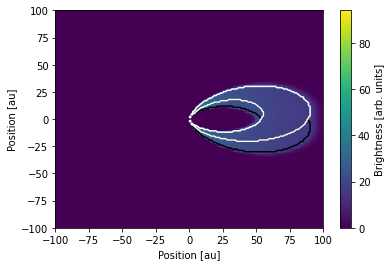

In [6]:
mask_f = em.compute_channel_mask(v_obs, v_width=3)
mask_b = em.compute_channel_mask(v_obs, v_width=3, back=True)

I = em.compute_channel_map(v_obs)

plt.figure()
m = plt.pcolormesh(x, y, I.T)
plt.contour(x, y, mask_b.T, [0.5], colors='0')
plt.contour(x, y, mask_f.T, [0.5], colors='1')
plt.colorbar(m, label ='Brightness [arb. units]')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
None

## And the location of the surface

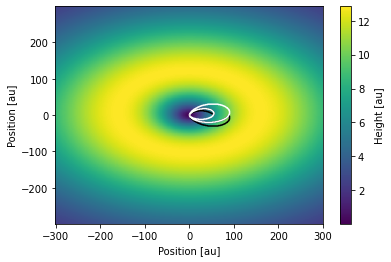

In [7]:
plt.figure()
m = plt.pcolormesh(x, y, em.surface_height_map().T)
plt.contour(x, y, mask_b.T, [0.5], colors='0')
plt.contour(x, y, mask_f.T, [0.5], colors='1')
plt.colorbar(m, label ='Height [au]')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')

None

## Now let's do a highly inclined disk

In [8]:
em2 = ThinSurfaceEmissionModel(x, y, zF, vk, vt, IR, tau, line_prof, 80*np.pi/180)

mask2_f = em2.compute_channel_mask(v_obs, v_width=3)
mask2_b = em2.compute_channel_mask(v_obs, v_width=3, back=True)

I2 = em2.compute_channel_map(v_obs)


front=True, slow=True, Iterations=7
front=False, slow=True, Iterations=7


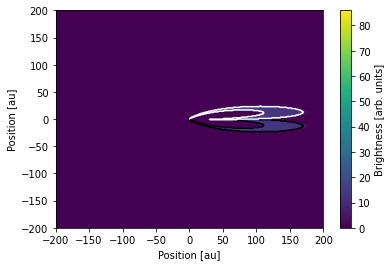

In [9]:

plt.figure()
m = plt.pcolormesh(x, y, I2.T)
plt.contour(x, y, mask2_b.T, [0.5], colors='0')
plt.contour(x, y, mask2_f.T, [0.5], colors='1')
plt.colorbar(m, label ='Brightness [arb. units]')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')
plt.xlim(-200, 200)
plt.ylim(-200, 200)
None

(-100.0, 100.0)

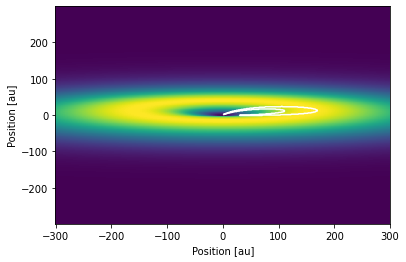

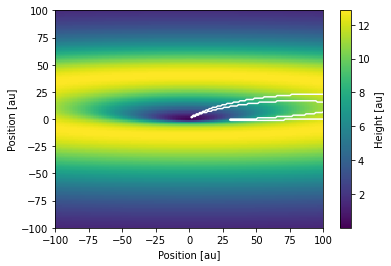

In [10]:
plt.figure()
plt.pcolormesh(x, y, em2.surface_height_map().T)
plt.contour(x, y, mask2_f.T, [0.5], colors='1')
plt.colorbar(m, label ='Height [au]')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')

plt.figure()
plt.pcolormesh(x, y, em2.surface_height_map().T)
plt.colorbar(label ='Height [au]')
plt.contour(x, y, mask2_f.T, [0.5], colors='1')

plt.xlabel('Position [au]')
plt.ylabel('Position [au]')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

## And an even more extreme case
The channel maps are generally sensible, but a few pixels have failed to converge 

In [11]:
zfun = Z_surf(1.0, 2e2, 0.2)

em3 = ThinSurfaceEmissionModel(x, y, zfun, vk, vt, IR, tau, line_prof, 80*np.pi/180)

mask3_f = em3.compute_channel_mask(v_obs, v_width=3)
mask3_b = em3.compute_channel_mask(v_obs, v_width=3, back=True)

I3 = em3.compute_channel_map(v_obs)

front=True, slow=True, Repaired 8 failed pixels, Iterations=104
front=False, slow=True, Repaired 11 failed pixels, Iterations=104


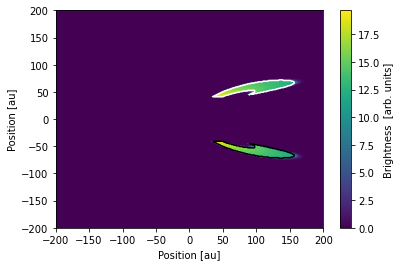

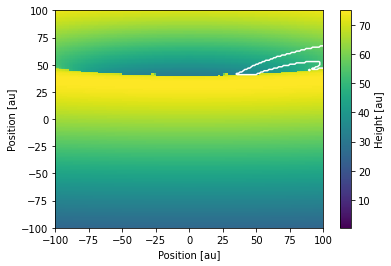

In [12]:

plt.figure()
plt.pcolormesh(x, y, I3.T)
plt.colorbar(label ='Brightness  [arb. units]')
plt.contour(x, y, mask3_b.T, [0.5], colors='0')
plt.contour(x, y, mask3_f.T, [0.5], colors='1')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

plt.figure()
plt.pcolormesh(x, y, em3.surface_height_map().T)
plt.colorbar(label ='Height [au]')
plt.contour(x, y, mask3_f.T, [0.5], colors='1')

plt.xlabel('Position [au]')
plt.ylabel('Position [au]')
plt.xlim(-100, 100)
plt.ylim(-100, 100)

None

In this very extreme case, the model can break down. Here the line separating the near and far side of the disc front surface isn't smooth and it should be. The result only affects a small number of pixels.

### Low velocity channels can have odd-looking channel maps

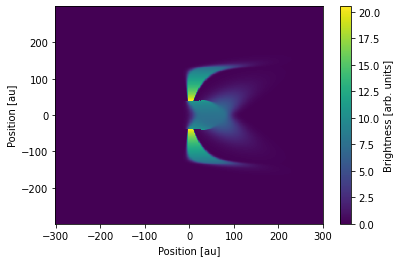

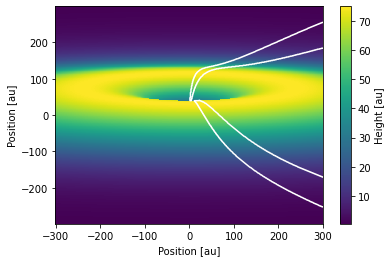

In [13]:
plt.figure()
plt.pcolormesh(x, y, em3.compute_channel_map(2e4).T)
plt.colorbar(label ='Brightness [arb. units]')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')


plt.figure()
plt.pcolormesh(x, y, em3.surface_height_map().T)
plt.colorbar(label ='Height [au]')
plt.contour(x, y, em3.compute_channel_mask(2e4).T, [0.5], colors='1')
plt.xlabel('Position [au]')
plt.ylabel('Position [au]')

None

## Timings
Let's check how long the code takes to do the three cases here.

In [14]:
def easy_model():
    zF = Z_surf(0.3, 100, 0.6)
    em = ThinSurfaceEmissionModel(x, y, zF, vk, vt, IR, tau, line_prof, 45*np.pi/180, verbose=False)
    return em.compute_channel_map(2e5)

def moderate_model():
    zF = Z_surf(0.3, 100, 0.6)
    em = ThinSurfaceEmissionModel(x, y, zF, vk, vt, IR, tau, line_prof, 80*np.pi/180, verbose=False)
    return em.compute_channel_map(2e5)

def hard_model():
    zF = Z_surf(1.0, 100, 0.6)
    em = ThinSurfaceEmissionModel(x, y, zF, vk, vt, IR, tau, line_prof, 80*np.pi/180, verbose=False)
    return em.compute_channel_map(2e5)

In [15]:
%%timeit
easy_model()
None

98.6 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
moderate_model()
None

266 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
hard_model()
None

335 ms ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
